<h1>Convolutional Neural Network with Batch-Normalization </h1> 


In [7]:

# Import the libraries 

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<h2 id="Makeup_Data">Get the Data</h2> 


In [2]:

IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [3]:

train_dataset = dsets.MNIST(root='../Datasets', train=True, download=False, transform=composed)

Load the testing dataset by setting the parameters train  <code>False</code>.


In [4]:
# Make the validating 

validation_dataset = dsets.MNIST(root='../Datasets', train=False, download=False, transform=composed)

In [6]:
# The label for the fourth data element

train_dataset[3][1]

1

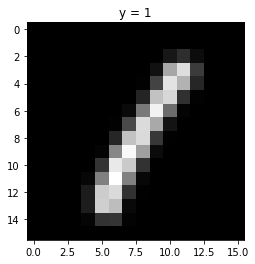

In [8]:
# The image for the fourth data element
show_data(train_dataset[3])


<h2 id="CNN">Build a Two Convolutional Neural Network Class</h2>


In [9]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [10]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [17]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print('Epoch: {}/{}, training loss: {}, validation accuracy:{}'.format(epoch+1, n_epochs, loss, accuracy))
 
    return accuracy_list, loss_list

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2> 


In [12]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

In [13]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [18]:
# Train the model
accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=5,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

Epoch: 1/5, training loss: 0.33648085594177246, validation accuracy:0.9693
Epoch: 2/5, training loss: 0.3418908417224884, validation accuracy:0.973
Epoch: 3/5, training loss: 0.32510387897491455, validation accuracy:0.9743
Epoch: 4/5, training loss: 0.30441123247146606, validation accuracy:0.9765
Epoch: 5/5, training loss: 0.29277947545051575, validation accuracy:0.9794


In [19]:
model_batch=CNN_batch(out_1=16, out_2=32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=5,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

Epoch: 1/5, training loss: 0.11581117659807205, validation accuracy:0.9605
Epoch: 2/5, training loss: 0.10356102883815765, validation accuracy:0.9723
Epoch: 3/5, training loss: 0.09680401533842087, validation accuracy:0.9832
Epoch: 4/5, training loss: 0.09100322425365448, validation accuracy:0.9823
Epoch: 5/5, training loss: 0.08298958837985992, validation accuracy:0.9866


<h2 id="Result">Analyze Results</h2> 


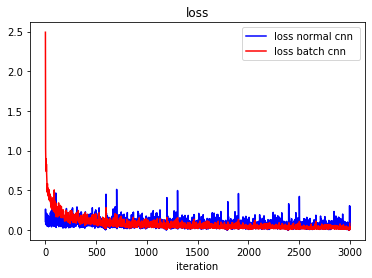

In [20]:
# Plot the loss and accuracy

plt.plot(loss_list_normal, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

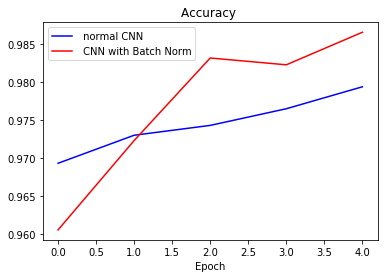

In [21]:
plt.plot(accuracy_list_normal, 'b',label=' normal CNN')
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()